In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et
from salishsea_tools import geo_tools, viz_tools
import pickle
import cmocean
%matplotlib inline

(200, 800)

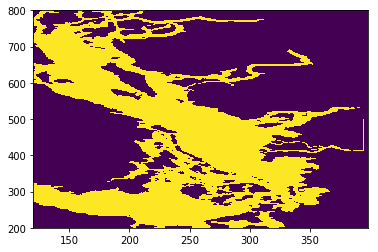

In [34]:
mesh=nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
tmask=mesh.variables['tmask']
plt.pcolormesh(tmask[0,0,:,:])
plt.xlim(120,398)
plt.ylim(200,800)

In [35]:
tstart=dt.datetime(2017,1,1)
tend=dt.datetime(2017,12,31)

In [36]:
f=nc.Dataset('/data/eolson/results/MEOPAR/ariane-2.2.8_04-new/experiment/ariane_trajectories_qualitative.nc')

In [37]:
f.variables.keys()

odict_keys(['init_x', 'init_y', 'init_z', 'init_t', 'init_age', 'init_transp', 'final_x', 'final_y', 'final_z', 'final_t', 'final_age', 'final_transp', 'traj_lon', 'traj_lat', 'traj_depth', 'traj_time'])

In [38]:
f.variables['traj_depth']

<class 'netCDF4._netCDF4.Variable'>
float64 traj_depth(nb_output, ntraj)
    title: What is traj_depth ?
    longname: Trajectory: z positions
    units: No dimension
    missing_value: 1e+20
unlimited dimensions: nb_output
current shape = (49, 550)
filling on, default _FillValue of 9.969209968386869e+36 used

0.15190937982505343 6.18986054832445
0.2416848816615188 18.178118307201647
0.07530515839668846 2.468626444852687
0.017647101219431173 1.2358576897120002
-0.0005350704087321461 0.993599724671627
-0.0002102419807122762 0.9974802760784539
0.023880385348686823 1.3318442344603778
0.0677543383460932 2.2547792174414614
0.052139041067949456 1.8694952839685355
0.051410087521263456 1.8532132980453244


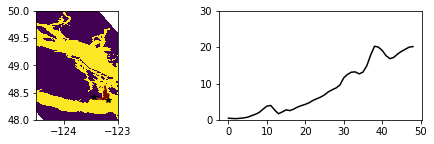

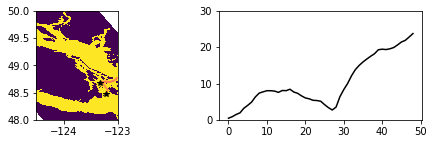

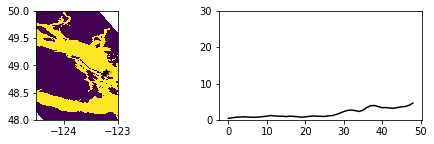

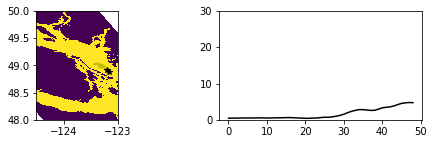

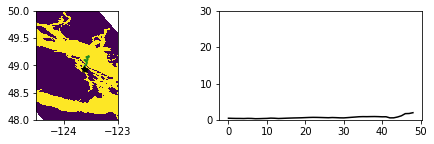

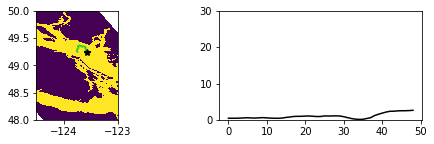

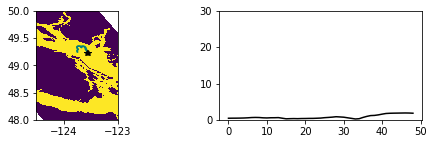

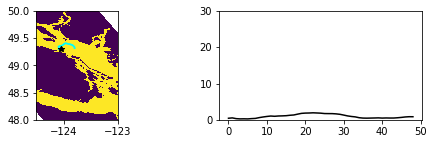

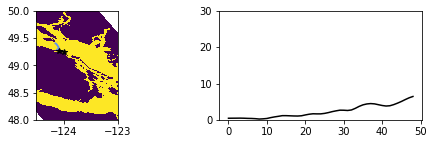

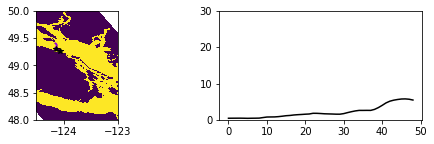

In [39]:

cols=['maroon','coral','orange','y','forestgreen','limegreen','teal','cyan','cornflowerblue','darkviolet','orchid','magenta']
for ii in range(0,10):
    fig,ax=plt.subplots(1,2,figsize=(8,2))
    ax[0].pcolormesh(mesh.variables['nav_lon'],mesh.variables['nav_lat'],tmask[0,0,:,:])
    ax[0].plot(f.variables['traj_lon'][:,2*ii],f.variables['traj_lat'][:,2*ii],'-',color=cols[ii])
    ax[0].plot(f.variables['traj_lon'][:,2*ii+1],f.variables['traj_lat'][:,2*ii+1],'-',color=cols[ii])
    ax[0].plot(f.variables['traj_lon'][-1,2*ii],f.variables['traj_lat'][-1,2*ii],'k*')
    ax[0].plot(f.variables['traj_lon'][-1,2*ii+1],f.variables['traj_lat'][-1,2*ii+1],'k*')
    ax[0].set_xlim(-124.5,-123)
    ax[0].set_ylim(48,50)
    ax[0].set_aspect(1)
    sep=[geo_tools.haversine(lon1, lat1, lon2, lat2) for lon1,lat1,lon2,lat2 \
         in zip(f.variables['traj_lon'][:,2*ii],f.variables['traj_lat'][:,2*ii],f.variables['traj_lon'][:,2*ii+1],
               f.variables['traj_lat'][:,2*ii+1])]
    ax[1].plot(sep,'k-')
    ax[1].set_ylim((0,30))
    print(1/12*np.log(sep[12]/sep[0]),sep[12]/sep[0])

In [40]:
f['init_t'][0:6]

masked_array(data=[1193.24583333, 1193.24583333, 1196.48027778,
                   1196.48027778, 1198.40166667, 1198.40166667],
             mask=False,
       fill_value=1e+20)

In [41]:
for ii, x in enumerate(f['init_x'][0:6]):
    ix=x
    iy=f['init_y'][ii]
    iz=f['init_z'][ii]
    it=f['init_t'][ii]
    ii=ix+.5
    jj=iy+.5
    kk=iz-1.5
    ss=dt.timedelta(seconds=(it-.5)*3600)+tstart
    print(ii,jj,kk,ss)

241.0 329.0 0.0 2017-02-19 16:44:45
242.0 329.0 0.0 2017-02-19 16:44:45
292.0 344.0 0.0 2017-02-19 19:58:49
293.0 344.0 0.0 2017-02-19 19:58:49
281.0 371.0 1.0 2017-02-19 21:54:06
282.0 371.0 1.0 2017-02-19 21:54:06


In [42]:
f['traj_lon'][0,0],f['traj_lat'][0,0],f['traj_depth'][0,0]

(masked_array(data=-123.2427597,
              mask=False,
        fill_value=1e+20), masked_array(data=48.61288071,
              mask=False,
        fill_value=1e+20), masked_array(data=-0.5000006,
              mask=False,
        fill_value=1e+20))

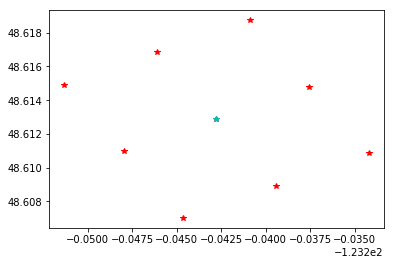

In [43]:
plt.plot(mesh.variables['nav_lon'][327:330,239:242],mesh.variables['nav_lat'][327:330,239:242],'r*')
plt.plot(f['traj_lon'][0,0],f['traj_lat'][0,0],'c*')

In [44]:
calcs=list()
for im in range(0,int(len(f['init_x'])/2)):
    ix=f['init_x'][2*im]
    iy=f['init_y'][2*im]
    iz=f['init_z'][2*im]
    it=f['init_t'][2*im]
    ii=int(ix-.5)
    jj=int(iy-.5)
    kk=int(iz-1.5)
    sep=[geo_tools.haversine(lon1, lat1, lon2, lat2) for lon1,lat1,lon2,lat2 \
         in zip(f.variables['traj_lon'][:,2*im],f.variables['traj_lat'][:,2*im],
                f.variables['traj_lon'][:,2*im+1],f.variables['traj_lat'][:,2*im+1])]

    Ly=1/12*np.log(sep[12]/sep[0])
    Lr=sep[12]/sep[0]
    calcs.append([ii,jj,kk,it,sep[12],Ly,Lr])
dfc=pd.DataFrame(data=calcs,columns=['i','j','k','atime','sep12','Ly','Lr'])

In [45]:
f2=nc.Dataset('/data/eolson/results/MEOPAR/ariane-2.2.8_04-new/experiment2/ariane_trajectories_qualitative.nc')

calcs=list()
for im in range(0,int(len(f2['init_x'])/2)):
    ix=f2['init_x'][2*im]
    iy=f2['init_y'][2*im]
    iz=f2['init_z'][2*im]
    it=f2['init_t'][2*im]
    ii=int(ix-.5)
    jj=int(iy-.5)
    kk=int(iz-1.5)
    sep=[geo_tools.haversine(lon1, lat1, lon2, lat2) for lon1,lat1,lon2,lat2 \
         in zip(f2.variables['traj_lon'][:,2*im],f2.variables['traj_lat'][:,2*im],
                f2.variables['traj_lon'][:,2*im+1],f2.variables['traj_lat'][:,2*im+1])]

    Ly=1/12*np.log(sep[12]/sep[0])
    Lr=sep[12]/sep[0]
    calcs.append([ii,jj,kk,it,sep[12],Ly,Lr])
dfc=pd.DataFrame(data=calcs,columns=['i','j','k','atime','sep12','Ly','Lr'])

In [46]:
f2['init_x'][0:5]

masked_array(data=[120.5, 121.5, 120.5, 121.5, 120.5],
             mask=False,
       fill_value=1e+20)

In [47]:
dfc.head()

,i,j,k,atime,sep12,Ly,Lr
0,120,275,0,2376.5,4.604456,0.195329,10.422304
1,120,278,0,2376.5,5.274087,0.206678,11.942950
2,120,281,0,2376.5,1.074469,0.074045,2.431590
3,120,284,0,2376.5,2.059577,0.128330,4.664376
4,120,287,0,2376.5,0.048345,-0.184313,0.109508


In [48]:
len(dfc.loc[(dfc['i']==126)&(dfc['j']==797),['sep12']].values),len(dfc.loc[(dfc['i']==127)&(dfc['j']==797),['sep12']].values)

(1, 0)

In [49]:
tmask

<class 'netCDF4._netCDF4.Variable'>
int8 tmask(t, z, y, x)
    standard_name: tmask
    long_name: mask for T-grid and W-grid
    flag_values: 0, 1
    flag_meanings: land, water
unlimited dimensions: t
current shape = (1, 40, 898, 398)
filling on, default _FillValue of -127 ignored

In [50]:
aS=np.nan*np.ones((len(np.arange(200,800,3)),len(np.arange(120,355,3))))
aLy=np.nan*np.ones((len(np.arange(200,800,3)),len(np.arange(120,355,3))))
aLr=np.nan*np.ones((len(np.arange(200,800,3)),len(np.arange(120,355,3))))
iit=-1
for ii in np.arange(120,355,3):
    iit=iit+1
    jjt=-1
    for jj in np.arange(200,800,3):
        jjt=jjt+1
        if (tmask[0,0,jj,ii]==1) and len(dfc.loc[(dfc['i']==ii)&(dfc['j']==jj),['sep12']].values)==1:
            aS[jjt,iit]=dfc.loc[(dfc['i']==ii)&(dfc['j']==jj),['sep12']].values[0]
            aLy[jjt,iit]=dfc.loc[(dfc['i']==ii)&(dfc['j']==jj),['Ly']].values[0]
            aLr[jjt,iit]=dfc.loc[(dfc['i']==ii)&(dfc['j']==jj),['Lr']].values[0]

In [51]:
np.shape(aS)

(200, 79)

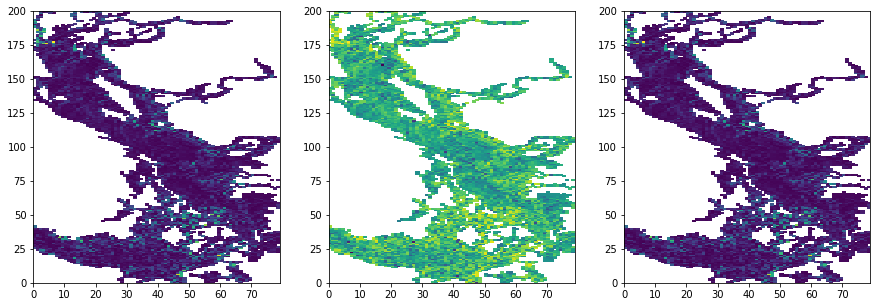

In [52]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].pcolormesh(np.ma.masked_where(np.isnan(aS),aS))
ax[1].pcolormesh(np.ma.masked_where(np.isnan(aLy),aLy))
ax[2].pcolormesh(np.ma.masked_where(np.isnan(aLr),aLr))

In [53]:
np.min(f2.variables['init_y']),np.max(f2.variables['init_y'])

(200.5, 797.5)

In [54]:
aS

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan, 0.27599732, ...,        nan,        nan,
               nan],
       [       nan,        nan, 7.98916796, ...,        nan,        nan,
               nan],
       [       nan,        nan, 4.70793601, ...,        nan,        nan,
               nan]])

In [55]:
f3=nc.Dataset('/data/eolson/results/MEOPAR/ariane-2.2.8_04-new/experiment2OldHC/ariane_trajectories_qualitative.nc')

In [56]:
len(f2['init_x']),len(f3['init_x'])

(13196, 13196)

In [57]:
calcs=list()
for im in range(0,int(len(f2['init_x'])/2)):
    ix=f2['init_x'][2*im]
    iy=f2['init_y'][2*im]
    iz=f2['init_z'][2*im]
    it=f2['init_t'][2*im]
    ii=int(ix-.5)
    jj=int(iy-.5)
    kk=int(iz-1.5)
    sep2=[geo_tools.haversine(lon1, lat1, lon2, lat2) for lon1,lat1,lon2,lat2 \
         in zip(f2.variables['traj_lon'][:,2*im],f2.variables['traj_lat'][:,2*im],
                f3.variables['traj_lon'][:,2*im],f3.variables['traj_lat'][:,2*im])]

    Ly2=1/11*np.log(sep2[12]/sep2[1])
    Lr2=sep2[12]/sep2[1]
    calcs.append([ii,jj,kk,it,sep2[12],Ly2,Lr2])
dfc2=pd.DataFrame(data=calcs,columns=['i','j','k','atime','sep12','Ly','Lr'])

In [58]:
aS2=np.nan*np.ones((len(np.arange(200,800,3)),len(np.arange(120,355,3))))
aLy2=np.nan*np.ones((len(np.arange(200,800,3)),len(np.arange(120,355,3))))
aLr2=np.nan*np.ones((len(np.arange(200,800,3)),len(np.arange(120,355,3))))
iit=-1
for ii in np.arange(120,355,3):
    iit=iit+1
    jjt=-1
    for jj in np.arange(200,800,3):
        jjt=jjt+1
        if (tmask[0,0,jj,ii]==1) and len(dfc2.loc[(dfc2['i']==ii)&(dfc2['j']==jj),['sep12']].values)==1:
            aS2[jjt,iit]=dfc2.loc[(dfc2['i']==ii)&(dfc2['j']==jj),['sep12']].values[0]
            aLy2[jjt,iit]=dfc2.loc[(dfc2['i']==ii)&(dfc2['j']==jj),['Ly']].values[0]
            aLr2[jjt,iit]=dfc2.loc[(dfc2['i']==ii)&(dfc2['j']==jj),['Lr']].values[0]

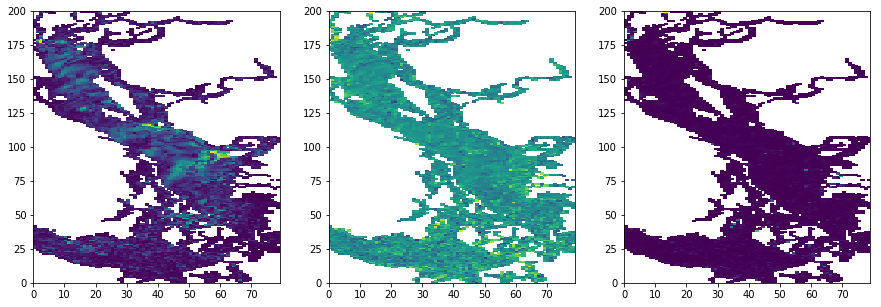

In [59]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
m=ax[0].pcolormesh(np.ma.masked_where(np.isnan(aS2),aS2))
ax[1].pcolormesh(np.ma.masked_where(np.isnan(aLy2),aLy2))
ax[2].pcolormesh(np.ma.masked_where(np.isnan(aLr2),aLr2))

Text(0.5, 1.0, 'Lateral Separation at 12 Hours (km)')

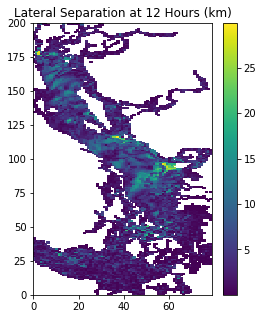

In [60]:
fig,ax=plt.subplots(1,1,figsize=(4,5))
m=ax.pcolormesh(np.ma.masked_where(np.isnan(aS2),aS2))
fig.colorbar(m,ax=ax)
ax.set_title('Lateral Separation at 12 Hours (km)')

In [61]:
np.nanmin(aS2)

0.0005765106129028887

In [62]:
fOld=nc.Dataset('/results2/SalishSea/nowcast-green.201806/10apr17/SalishSea_1h_20170410_20170410_grid_T.nc')
fNew=nc.Dataset('/data/eolson/results/MEOPAR/SS36runs/linkHC201812/10apr17/SalishSea_1h_20170410_20170410_grid_T.nc')

In [63]:
cm1=cmocean.cm.thermal
cm1.set_bad('k')
cm2=cmocean.cm.tarn
cm2.set_bad('k')

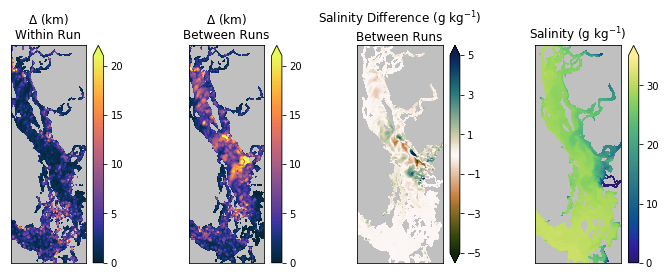

In [70]:
fig,ax=plt.subplots(1,4,figsize=(10,4))
fig.subplots_adjust(left=0,right=.95)
iax=ax[0]
m=iax.contourf(np.ma.masked_where(np.isnan(aS),aS),np.linspace(0,21,100),cmap=cm1,extend='max')
viz_tools.set_aspect(iax,coords='grid')
fig.colorbar(m,ax=iax,ticks=(0,5,10,15,20))
iax.set_xticks(());
iax.set_yticks(());
iax.set_title('$\Delta$ (km)\nWithin Run')
iax.set_facecolor('silver')
iax=ax[1]
m=iax.contourf(np.ma.masked_where(np.isnan(aS2),aS2),np.linspace(0,21,100),cmap=cm1,extend='max')
viz_tools.set_aspect(iax,coords='grid')
fig.colorbar(m,ax=iax,ticks=(0,5,10,15,20))
iax.set_xticks(());
iax.set_yticks(());
iax.set_title('$\Delta$ (km)\nBetween Runs')
iax.set_facecolor('silver')
iax=ax[2]
m=iax.contourf(np.ma.masked_where(tmask[0,0,200:800,100:370]==0,
                fNew.variables['vosaline'][0,0,200:800,100:370]-fOld.variables['vosaline'][0,0,200:800,100:370]),
             np.linspace(-5,5,100),cmap=cm2,extend='both')# diff, tarn
fig.colorbar(m,ax=iax,ticks=(-5,-3,-1,1,3,5))
viz_tools.set_aspect(iax,coords='grid')
iax.set_facecolor('silver')
iax.set_xticks(());
iax.set_yticks(());
iax.set_title('Salinity Difference (g kg$^{-1}$)\nBetween Runs')
iax=ax[3]
m=iax.contourf(np.ma.masked_where(tmask[0,0,200:800,100:370]==0,
                fNew.variables['vosaline'][0,0,200:800,100:370]),
             np.linspace(0,35,100),cmap=cmocean.cm.haline,extend='max')# diff, tarn
fig.colorbar(m,ax=iax,ticks=(0,10,20,30))
viz_tools.set_aspect(iax,coords='grid')
iax.set_facecolor('silver')
iax.set_xticks(());
iax.set_yticks(());
iax.set_title('Salinity (g kg$^{-1}$)')
fig.savefig('/home/eolson/pyCode/notebooks/figs/trajectories.png',dpi=200,transparent=False)